# Modelo preditivo para a tendência do IBOVESPA

O objetivo desse projeto é desenvolver um modelo de Machine Learning capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com acuracidade mínima de 75% em um conjunto de teste composto pelos últimos 30 dias de dados.

> O Ibovespa é o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo. [Referência](https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm)

## Importação das bibliotecas

In [38]:
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import talib

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [39]:
# Configurar paleta de cores e estilo

# Matplotlib
mpl.rcParams["figure.figsize"] = (20, 7)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

# Seaborn
sns.set_style('whitegrid', {"grid.color": ".8", "grid.linestyle": "--"})
sns.set_palette(palette='mako')

## Aquisição dos dados

Utilizaremos os dados históricos do índice IBOVESPA, disponíveis publicamente no site do [br.investing](https://br.investing.com/indices/bovespa-historical-data)

In [40]:
df = pd.read_csv('../data/Dados_Historicos_Ibovespa_2008-2025.csv', thousands='.', decimal=',', parse_dates=['Data'], date_format='%d.%m.%Y', index_col='Data')
df = df.rename_axis('ds').sort_index()
df.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
ds,,,,,,
2025-06-12,137800,137127,137931,136175,"7,12B","0,49%"
2025-06-13,137213,137800,137800,136586,"8,63B","-0,43%"
2025-06-16,139256,137212,139988,137212,"7,62B","1,49%"
2025-06-17,138840,139256,139497,138293,"8,38B","-0,30%"
2025-06-18,138717,138844,139161,138443,"8,32B","-0,09%"


In [41]:
df.shape

(4315, 6)

In [42]:
# informações gerais do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4315 entries, 2008-01-18 to 2025-06-18
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Último    4315 non-null   int64 
 1   Abertura  4315 non-null   int64 
 2   Máxima    4315 non-null   int64 
 3   Mínima    4315 non-null   int64 
 4   Vol.      4314 non-null   object
 5   Var%      4315 non-null   object
dtypes: int64(4), object(2)
memory usage: 236.0+ KB


## Tratamento dos dados

Vamos transformar os dados brutos em um formato adequado para o treinamento de um modelo de Machine Learning.

In [43]:
# renomeando as colunas para os nomes padrões utilizados no mercado financeiro
colunas = {
  'Último': 'close',              # fechamento da negociação diária
  'Abertura': 'open',             # início da negociação diária
  'Máxima': 'high',               # valor máximo do dia
  'Mínima': 'low',                # valor mínimo do dia
  'Vol.': 'volume',               # volume de negociação diária
  'Var%': 'daily_return'          # variação percentual diária
}

df.rename(columns=colunas, inplace=True)

In [44]:
# Data mínima, máxima e total de anos do DF levando em conta os anos bissextos
print(f"Os dados vão de {df.index.min().date()} até {df.index.max().date()}, o que dá aproximadamente {(df.index.max() - df.index.min()).days / 365.25:.0f} anos")

Os dados vão de 2008-01-18 até 2025-06-18, o que dá aproximadamente 17 anos


In [45]:
# conferindo se há valores duplicados
df.duplicated().sum()

np.int64(0)

In [46]:
# conferindo se há valores nulos
df.isnull().sum()

close           0
open            0
high            0
low             0
volume          1
daily_return    0
dtype: int64

In [47]:
df[df['volume'].isnull()]

,close,open,high,low,volume,daily_return
ds,,,,,,
2016-02-10,40377,40592,40592,39960,NaN,"-0,53%"


In [48]:
# Já que é apenas 1 caso com valor nulo, vamos excluí-lo
df.dropna(inplace=True)

In [49]:
# ajustando a coluna volume (de texto para float)
def converter_volume(vol):
  vol = vol.upper().replace(',', '.').strip()
  if vol.endswith('B'):
      return float(vol[:-1]) * 1e9
  elif vol.endswith('M'):
      return float(vol[:-1]) * 1e6
  elif vol.endswith('K'):
      return float(vol[:-1]) * 1e3
  else:
      return float(vol)

df['volume'] = df['volume'].apply(converter_volume)

In [50]:
# ajustando a coluna variação percentual diária
df['daily_return'] = df['daily_return'].str.replace('%', '').str.replace(',', '.')
df['daily_return'] = df['daily_return'].astype(float) / 100
df.head()

,close,open,high,low,volume,daily_return
ds,,,,,,
2008-01-18,57506,57039,58291,56241,5810000.0,0.0082
2008-01-21,53709,57503,57503,53487,3570000.0,-0.0660
2008-01-22,56097,53705,56541,53610,3650000.0,0.0445
2008-01-23,54235,56098,56098,53011,3720000.0,-0.0332
2008-01-24,57463,54242,57675,54242,3800000.0,0.0595


In [51]:
# conferindo formato dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4314 entries, 2008-01-18 to 2025-06-18
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   close         4314 non-null   int64  
 1   open          4314 non-null   int64  
 2   high          4314 non-null   int64  
 3   low           4314 non-null   int64  
 4   volume        4314 non-null   float64
 5   daily_return  4314 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 235.9 KB


## Engenharia de atributos

Primeiro, vamos criar a **variável alvo** com horizonte de 1 dia para que o modelo de classificação consiga prever se o fechamento de amanhã será maior que o de hoje.

* `1` para dias de **Alta**
* `0` para dias de **Baixa**

In [52]:
# criando uma coluna de direção (baixa = 0 ou alta = 1)
target_values = (df['close'].shift(-1) > df['close']).astype(int)
df.insert(0, 'target', target_values)

Agora, vamos criar **variáveis preditoras** através de uma análise técnica do mercado financeiro, ao invés de uma análise fundamentalista. Para as janelas de tempo, vamos utilizar as convenções do mercado financeiro para representar uma semana (5 dias), um mês (21 dias) e um trimestre (63 dias) de transações.

In [53]:
# indicadores de momentum

# retorno percentual de 1 a 5 dias (tendência de curto prazo)
for lag in range(1, 6):
    df[f'return_lag_{lag}'] = df['daily_return'].shift(lag)

# retorno percentual acumulado de uma semana, um mês e um trimestre
for period in [5, 21, 63]:
    df[f'momentum_{period}'] = df['close'].pct_change(period)

In [54]:
# indicadores de tendência

# média móvel simples de um mês (tendência de médio prazo)
df['sma_21'] = talib.SMA(df['close'], timeperiod=21)

# média móvel exponencial de um trimestre (tendência de longo prazo)
df['ema_200'] = talib.EMA(df['close'], timeperiod=200)

Para a média móvel exponencial, é uma convenção utilizar 50 dias ou 200 dias para tendências de longo prazo. [Referência](https://www.investopedia.com/terms/e/ema.asp#citation-4)

In [55]:
# indicadores de osciladores

# índice de força relativa (IFR) varia de 0 a 100
df['rsi_14'] = talib.RSI(df['close'], timeperiod=14)

Por padrão, utiliza-se um período de 14 dias para o IFR. [Referência](https://blog.quantinsti.com/rsi-indicator/)

In [56]:
# indicadores de volatilidade

# average true range
df['atr_14'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)

Por padrão, utiliza-se um período de 14 dias para o ATR. [Referência](https://www.investopedia.com/terms/a/atr.asp)

In [57]:
# indicadores de volume
# CONFERIR SE O VOLUME DE BILHÃO DO BR.INVESTING TÁ CERTO ANTES DE FAZER AS FEATURES C ELE

In [58]:
# indicadores de data

# dia da semana (segunda=0 a sexta=4)
df['day_of_week'] = df.index.dayofweek

# dia do mês (1 a 30 ou 31)
df['day_of_month'] = df.index.day

# mês (janeiro=1 a dezembro=12)
df['month'] = df.index.month

In [59]:
# selecionando apenas 10 anos de dados
df_10years = df.loc[df.index >= '2015-06-17']
df_10years.head()

,target,close,open,high,low,volume,daily_return,return_lag_1,return_lag_2,return_lag_3,...,momentum_5,momentum_21,momentum_63,sma_21,ema_200,rsi_14,atr_14,day_of_week,day_of_month,month
ds,,,,,,,,,,,,,,,,,,,,,
2015-06-17,1,53249,53698,53755,52965,3090000.0,-0.0084,0.0106,-0.0039,-0.0064,...,-0.011638,-0.052576,0.090096,53785.285714,52964.752143,44.356672,889.081392,2,17,6
2015-06-18,0,54239,53251,54352,53214,2750000.0,0.0186,-0.0084,0.0106,-0.0039,...,0.010244,-0.022703,0.078632,53725.285714,52977.431226,51.525407,906.861293,3,18,6
2015-06-19,1,53749,54236,54236,53479,2950000.0,-0.0090,0.0186,-0.0084,0.0106,...,0.007517,-0.020983,0.043143,53670.428571,52985.108527,48.214460,896.371201,4,19,6
2015-06-22,0,53864,53750,54342,53655,2430000.0,0.0021,-0.0090,0.0186,-0.0084,...,0.013663,-0.022645,0.057110,53611.000000,52993.853716,49.042076,881.416115,0,22,6
2015-06-23,1,53772,53865,54361,53772,2710000.0,-0.0017,0.0021,-0.0090,0.0186,...,0.001303,-0.011126,0.034734,53582.190476,53001.596465,48.375998,860.529250,1,23,6


In [60]:
df_10years.isnull().sum()

target          0
close           0
open            0
high            0
low             0
volume          0
daily_return    0
return_lag_1    0
return_lag_2    0
return_lag_3    0
return_lag_4    0
return_lag_5    0
momentum_5      0
momentum_21     0
momentum_63     0
sma_21          0
ema_200         0
rsi_14          0
atr_14          0
day_of_week     0
day_of_month    0
month           0
dtype: int64

## Análise exploratória

In [61]:
# resumo estatístico básico
df_10years.describe()

,target,close,open,high,low,volume,daily_return,return_lag_1,return_lag_2,return_lag_3,...,momentum_5,momentum_21,momentum_63,sma_21,ema_200,rsi_14,atr_14,day_of_week,day_of_month,month
count,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2.481000e+03,2481.000000,2481.000000,2481.000000,2481.000000,...,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000
mean,0.523176,95783.990326,95750.324063,96602.558646,94930.225312,4.885036e+08,0.000498,0.000503,0.000503,0.000494,...,0.002417,0.010378,0.030224,95445.139249,92681.299358,52.839578,1670.069057,1.999194,15.779121,6.498992
std,0.499563,26679.094016,26678.506166,26776.065462,26574.165509,2.275709e+09,0.014994,0.014996,0.014996,0.014994,...,0.031419,0.067818,0.116079,26565.256375,25816.082734,12.037642,664.482162,1.409358,8.744836,3.411570
min,0.000000,37497.000000,37501.000000,38031.000000,37046.000000,4.243200e+05,-0.147800,-0.147800,-0.147800,-0.147800,...,-0.290024,-0.454419,-0.435515,39050.857143,46033.577836,19.502335,682.015554,0.000000,1.000000,1.000000
25%,0.000000,74319.000000,74322.000000,75065.000000,73277.000000,3.930000e+06,-0.007200,-0.007200,-0.007200,-0.007200,...,-0.015072,-0.026938,-0.036696,74104.333333,69106.576237,44.092739,1293.908261,1.000000,8.000000,4.000000
50%,1.000000,102507.000000,102426.000000,103660.000000,101569.000000,7.620000e+06,0.000700,0.000700,0.000700,0.000700,...,0.002605,0.008774,0.029761,102533.952381,98785.562195,52.479259,1576.428158,2.000000,16.000000,7.000000
75%,1.000000,117426.000000,117381.000000,118290.000000,116269.000000,1.120000e+07,0.008400,0.008400,0.008400,0.008400,...,0.020902,0.051416,0.103309,116696.000000,112431.757783,61.554780,1907.551428,3.000000,23.000000,9.000000
max,1.000000,140110.000000,140109.000000,140382.000000,138966.000000,2.487000e+10,0.139100,0.139100,0.139100,0.139100,...,0.180126,0.275935,0.484615,137982.619048,130326.481240,84.282462,6755.132249,4.000000,31.000000,12.000000


In [62]:
# Gráfico de candlestick com abertura, fechamento, máxima e mínima
fig = go.Figure(data=[go.Candlestick(
    x=df_10years.index,
    open=df_10years['open'],
    high=df_10years['high'],
    low=df_10years['low'],
    close=df_10years['close'],
    name='OHLC',
    hovertext=[
        f"<b>Data</b>: {d.strftime('%d/%m/%Y')}<br>"
        f"<b>Abertura</b>: {o:.0f}<br>"
        f"<b>Máxima</b>: {h:.0f}<br>"
        f"<b>Mínima</b>: {l:.0f}<br>"
        f"<b>Fechamento</b>: {c:.0f}"
        for d, o, h, l, c in zip(df_10years.index, df_10years['open'], df_10years['high'], df_10years['low'], df_10years['close'])
    ],
    hoverinfo='text'
)])

# # Gráfico para a média móvel simples
# fig.add_trace(go.Scatter(
#     x=df_10years['ds'],
#     y=df_10years['sma_21'],
#     marker_color='blue',
#     name='MMS (21d)'
# ))

# Título e rótulos dos eixos
fig.update_layout(
    title=dict(text='Análise histórica do índice IBOVESPA' + '<br><sup>dos últimos 10 anos</sup>', x=0.5, font_size=20),
    xaxis=dict(title='Data'),                                                  
    yaxis=dict(title='Preço OHLC (R$)'),
    template='plotly_white',
    height=700
)

# Atualizar eixo X de 1 em 1 ano
fig.update_xaxes(
    dtick="M12",
    tickformat="%Y",
    rangeslider_visible=False
)

fig.show()

In [63]:
# Criar subplot na figura
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Gráfico de preço de fechamento
fig.add_trace(go.Scatter(
    x=df_10years.index,
    y=df_10years['close'],
    mode='lines',
    name='Preço de fechamento',
    line=dict(color='blue'),
    showlegend=False
), row=1, col=1)

# Gráfico de IFR
fig.add_trace(go.Scatter(
    x=df_10years.index,
    y=df_10years['rsi_14'],
    mode='lines',
    name='IFR',
    line=dict(color='orange'),
    showlegend=False
), row=2, col=1)

# Linhas horizontais para o IFR
fig.add_hline(y=70, line_dash='dash', line_color='red', annotation_text='Sobrecompra (70)', row=2, col=1)
fig.add_hline(y=30, line_dash='dash', line_color='green', annotation_text='Sobrevenda (30)', row=2, col=1)

# Título e rótulo dos eixos
fig.update_layout(
    title=dict(text='Preço de fechamento e IFR do IBOVESPA', x=0.5, font_size=20),
    xaxis2=dict(title='Data'),
    yaxis=dict(title='Preço de fechamento (R$)'),
    yaxis2=dict(range=[0,100], autorange=False, title='Índice de força relativa'),
    template='plotly_white',
    height=700
)

# Atualizar eixo X de 1 em 1 ano
fig.update_xaxes(
    dtick='M12',
    tickformat='%Y'
)

fig.show()

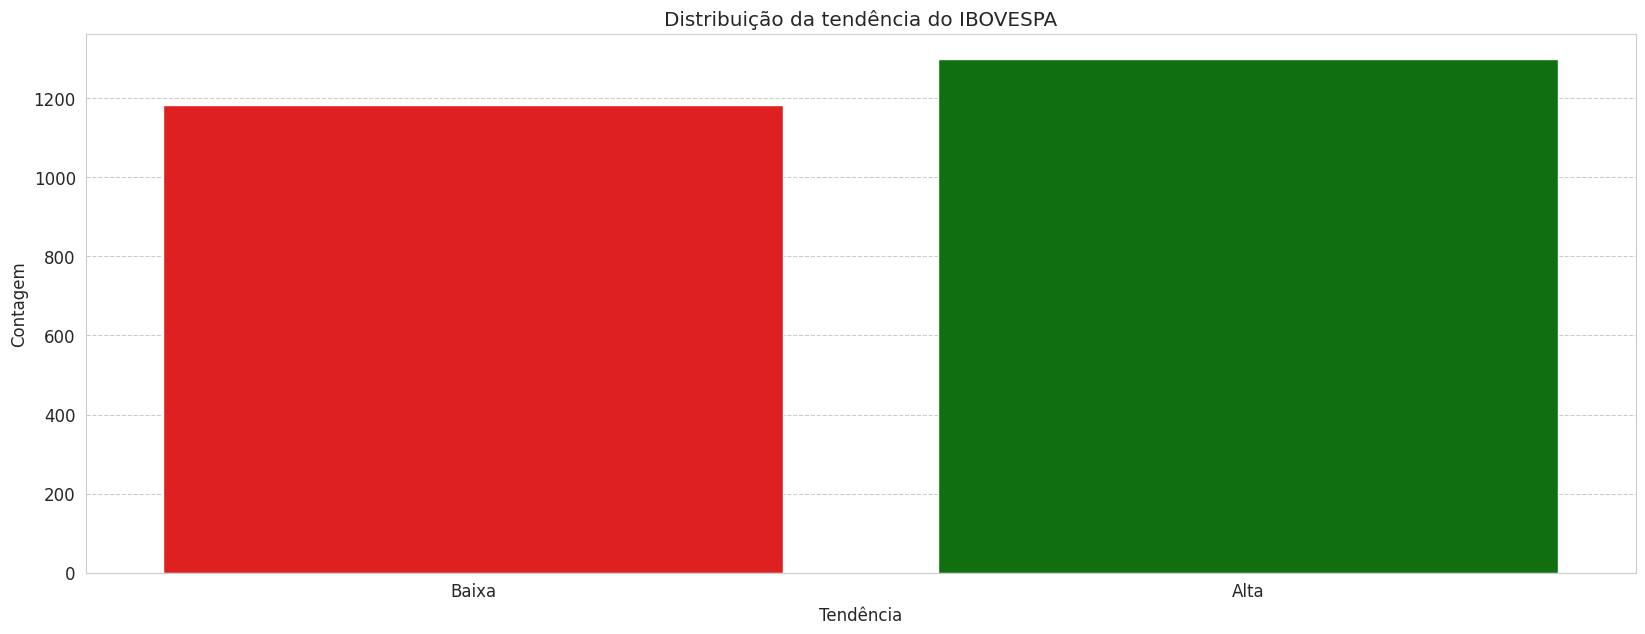

In [64]:
# Paleta
palette_green_red = {0: 'red', 1: 'green'}

# Gráfico de qtd de dias com tendência alta ou baixa
sns.countplot(data=df_10years, x='target', hue='target', palette=palette_green_red, legend=False)

# Título e rótulos dos eixos
plt.title('Distribuição da tendência do IBOVESPA')
plt.xlabel('Tendência')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Baixa', 'Alta'])

plt.show()

In [65]:
# Porcentagem da distribuição da tendência
df_10years['target'].value_counts(normalize=True)

target
1    0.523176
0    0.476824
Name: proportion, dtype: float64

Após a análise da distribuição da variável alvo, verificamos que o dataset é naturalmente balanceado. Portanto, a aplicação de técnicas de reamostragem como *oversampling* ou *undersampling* não se faz necessária.

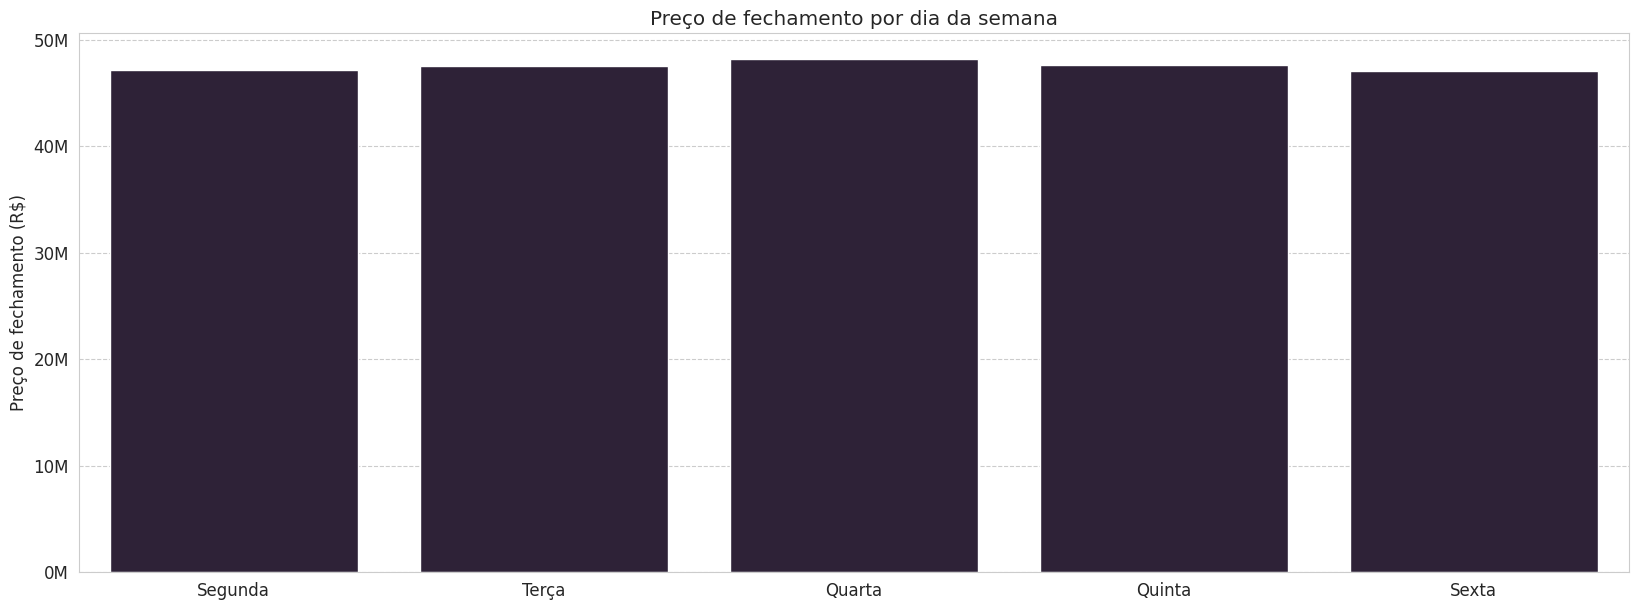

In [66]:
df_week = df_10years.groupby('day_of_week')['close'].sum().reset_index()

# Gráfico de barra de agrupamento por dia da semana
ax = sns.barplot(df_week, x='day_of_week', y='close')

# Título e rótulo dos eixos
plt.title('Preço de fechamento por dia da semana')
plt.ylabel('Preço de fechamento (R$)')
plt.xlabel('')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:,.0f}M'))
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta'])

plt.show()


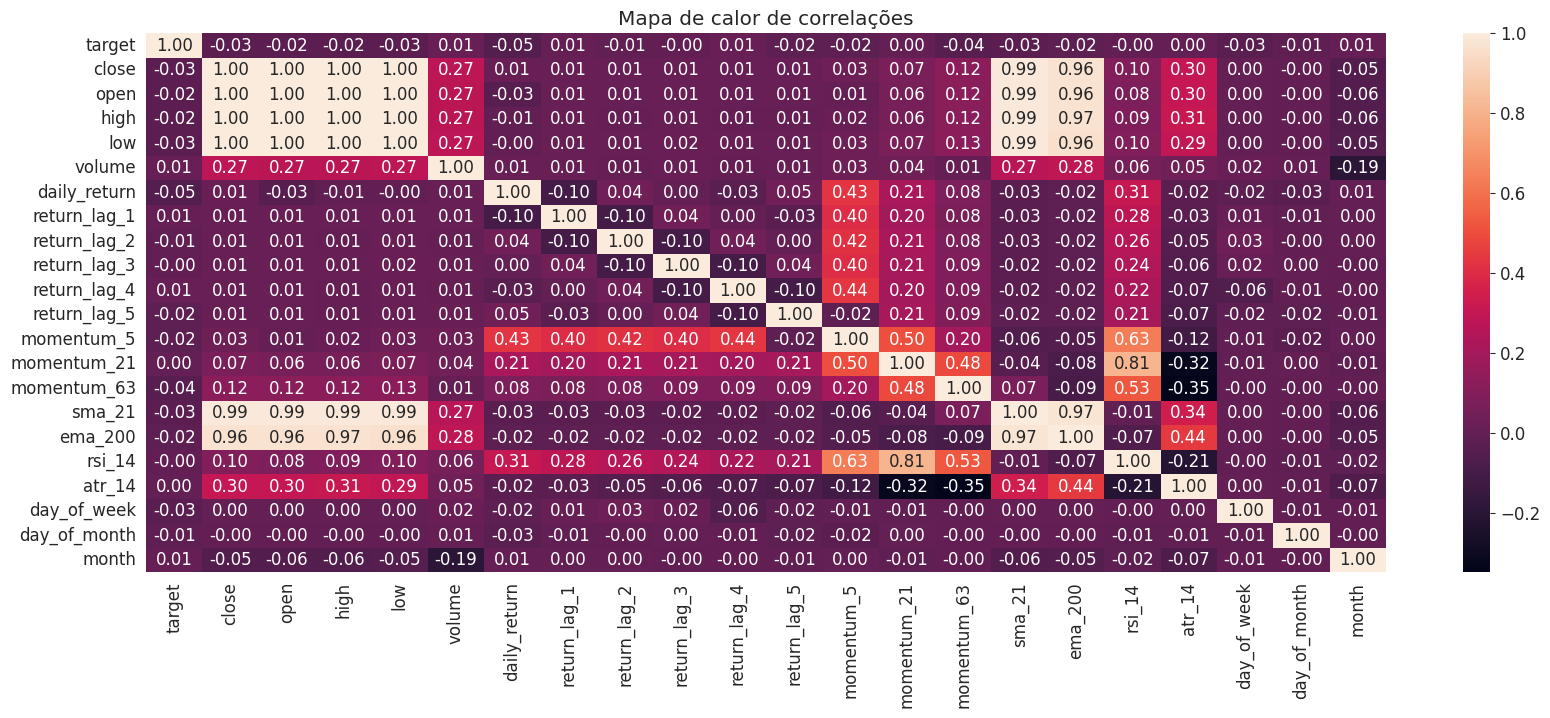

In [67]:
# mapa de calor de correlação das variáveis

corr = df_10years.corr(numeric_only=True)

sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Mapa de calor de correlações')
plt.show()

## Pré-processamento da base

## Construção do modelo

In [68]:
# definindo variáveis preditoras e variável alvo
remove_features = ['open', 'high', 'low', 'close', 'volume', 'target']
X = df_10years.drop(columns=remove_features)
y = df_10years['target']

In [69]:
# divisão entre treino e teste (30 dias de pregão, conforme requisito) de forma cronológica
test_days = 30
X_train = X[:-test_days]
X_test = X[-test_days:]
y_train = y[:-test_days]
y_test = y[-test_days:]

print(f"Tamanho do treino: {len(X_train)} amostras")
print(f"Tamanho do teste: {len(X_test)} amostras")

Tamanho do treino: 2451 amostras
Tamanho do teste: 30 amostras


In [70]:
# definindo modelos de classificação
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)
}

In [71]:
# treinando os modelos
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_train, y_train)

print("Todos os modelos foram treinados!")

Treinando Naive Bayes...
Treinando Decision Tree...
Treinando Random Forest...
Treinando XGBoost...
Todos os modelos foram treinados!


In [72]:
# comparando o desempenho dos modelos
performance = pd.DataFrame(
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    performance.loc[performance.shape[0]] = {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }
performance.set_index("Model", inplace=True)
performance = performance.map(lambda x: f"{100 * x:2.2f} %")
performance.sort_values("F1-Score", ascending=False, inplace=True)

performance

,Accuracy,Precision,Recall,F1-Score
Model,,,,
Random Forest,66.67 %,79.49 %,66.67 %,61.38 %
XGBoost,63.33 %,65.80 %,63.33 %,60.51 %
Decision Tree,50.00 %,50.22 %,50.00 %,50.06 %
Naive Bayes,53.33 %,28.44 %,53.33 %,37.10 %


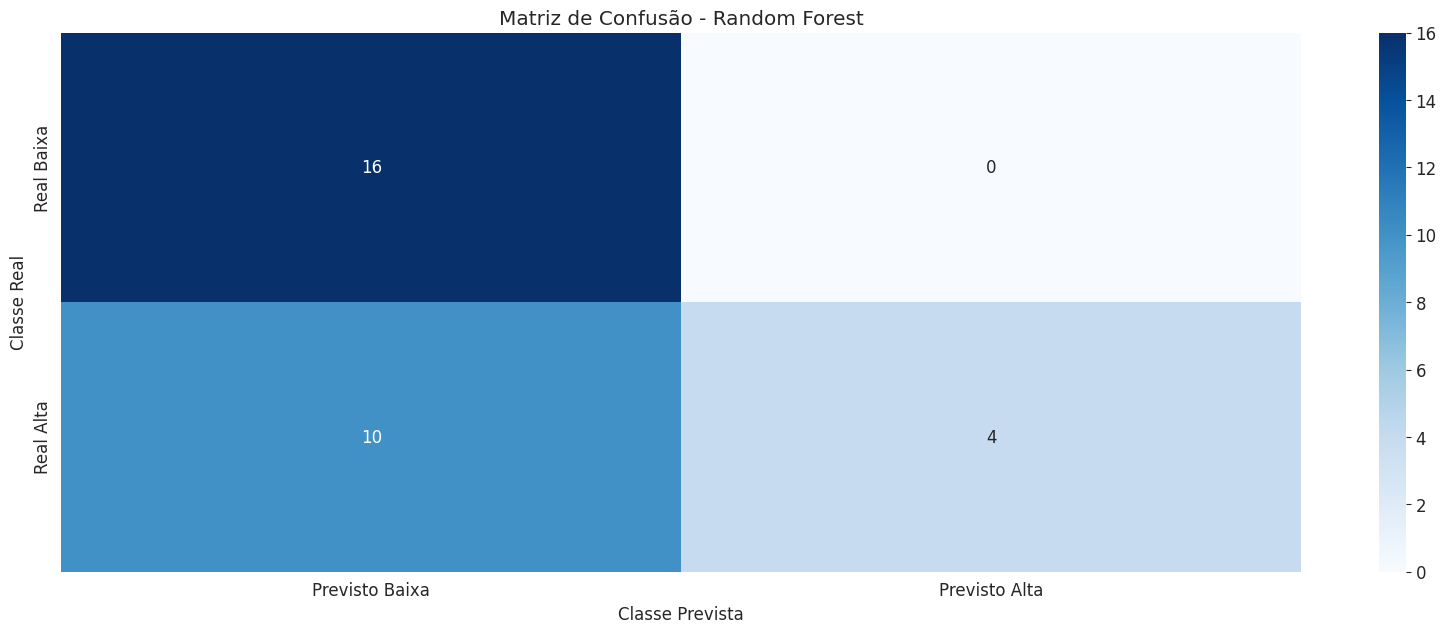

In [73]:
# matriz de confusão para o melhor modelo
best_model_name = performance.idxmax().iloc[0]
best_model = models[best_model_name]
cm = confusion_matrix(y_test, best_model.predict(X_test))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Previsto Baixa', 'Previsto Alta'], 
            yticklabels=['Real Baixa', 'Real Alta'])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

O modelo acerta muito bem a classe "Baixa", mas tem dificuldade de prever a classe "Alta".

Próximos passos:
* validação cruzada com `cross_val_score`
* ajuste de hiperparâmetros com `GridSearchCV`
* verificação da importância das variáveis (`model.feature_importances_`)